In [1]:
import pandas as pd

# Wczytanie danych
df = pd.read_csv('sport.csv')

# Wyświetlenie podstawowych informacji
print(df.head())
print(df.info())


   Unnamed: 0  sex        date  age  height  weight discipline  AeT  AnT  \
0           0    1  2023-07-21   45     184    81.0    running  128  157   
1           1    0  2023-08-04   33     171    64.0    running  171  184   
2           2    1  2023-08-04   38     185    72.0    running  157  178   
3           3    1  2023-08-04   37     182    81.0  triathlon  134  176   
4           4    1  2023-08-02   40     175    72.0    running  139  158   

   vo2max  ...  hr_10  la_10  hr_12  la_12  hr_14  la_14   z2   z3   z4   z5  
0    56.3  ...    133    3.2    138    3.3  149.0    3.5  121  129  149  158  
1    52.8  ...    168    5.2    180    1.6  186.0    1.8  154  172  178  185  
2    56.2  ...    128    1.2    140    1.0  152.0    1.2  138  158  167  179  
3    53.3  ...    127    1.9    143    2.3  162.0    2.6  123  135  162  177  
4    58.7  ...    132    1.0    145    3.2  158.0    5.7  126  140  152  159  

[5 rows x 29 columns]
<class 'pandas.core.frame.DataFrame'>
RangeInd

In [2]:
df = df.drop(columns=['Unnamed: 0'])


              age      height      weight      vo2max
count  100.000000  100.000000  100.000000  100.000000
mean    38.960000  171.256912   68.323627   39.317685
std     12.703233    9.886570   13.949804    5.042324
min     20.000000  152.737174   36.648953   26.137036
25%     28.750000  163.230480   59.069414   36.523938
50%     38.500000  170.915387   67.716798   39.206899
75%     51.000000  179.021310   79.434347   42.687743
max     59.000000  193.831448  103.889634   51.519583
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     100 non-null    int32  
 1   height  100 non-null    float64
 2   weight  100 non-null    float64
 3   vo2max  100 non-null    float64
dtypes: float64(3), int32(1)
memory usage: 2.9 KB
None


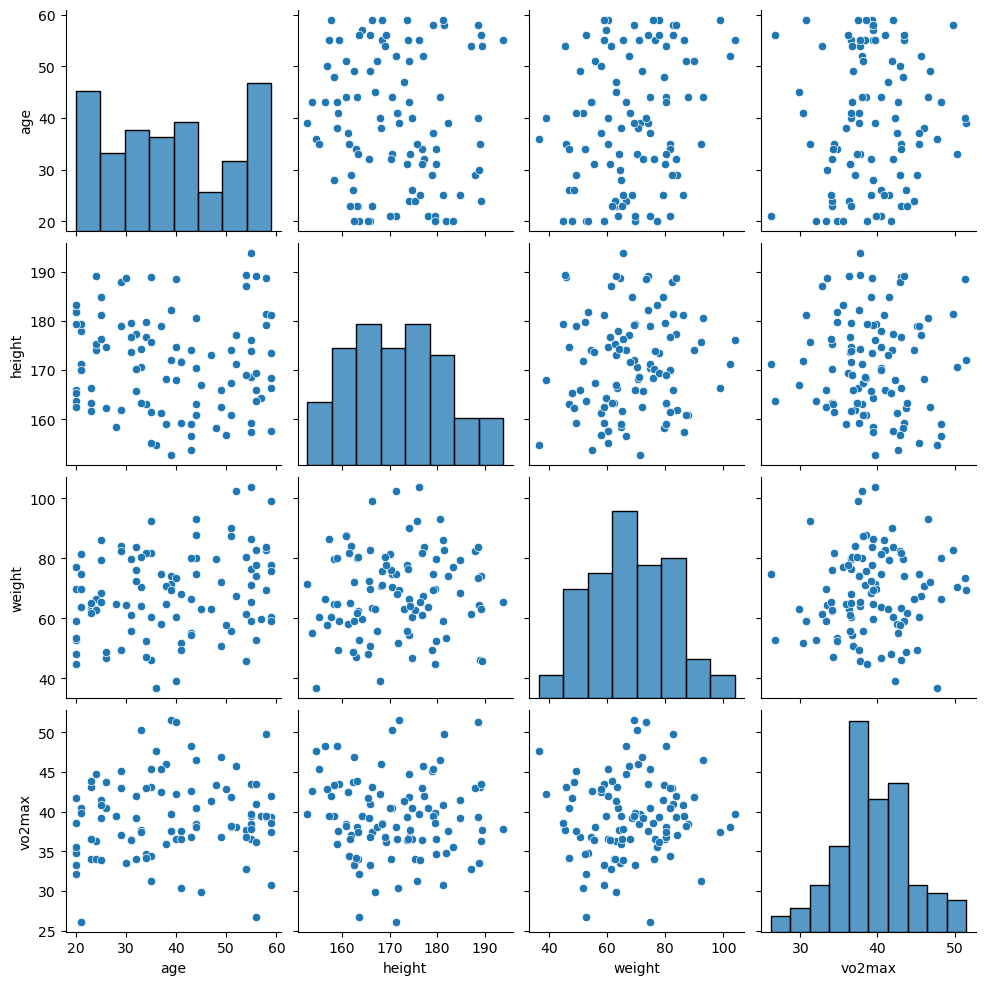

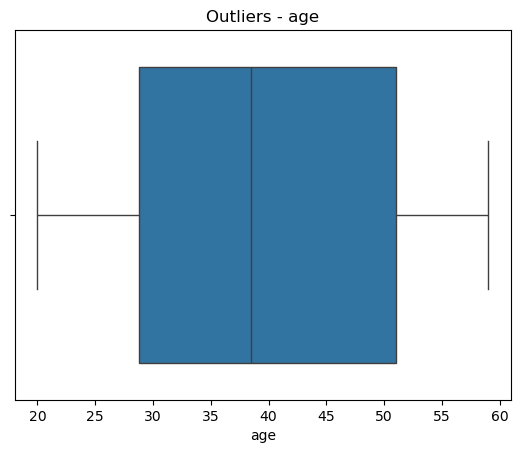

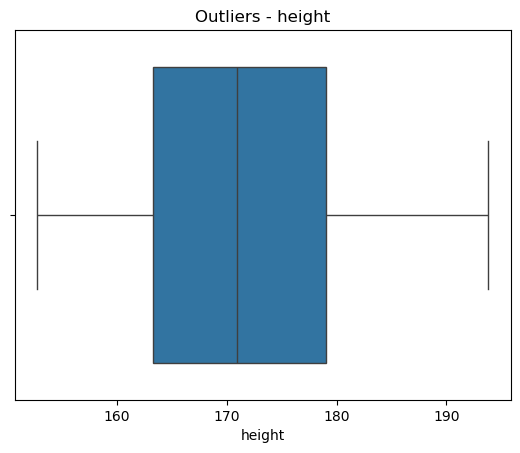

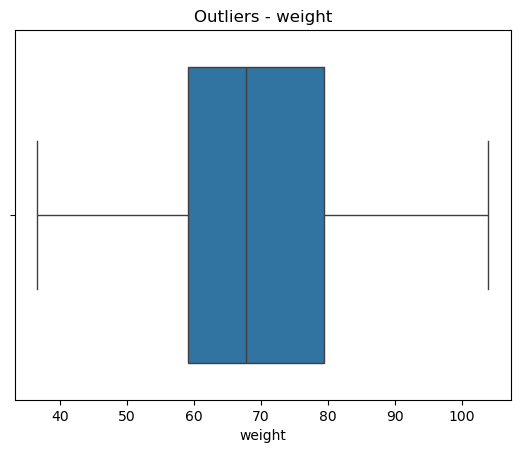

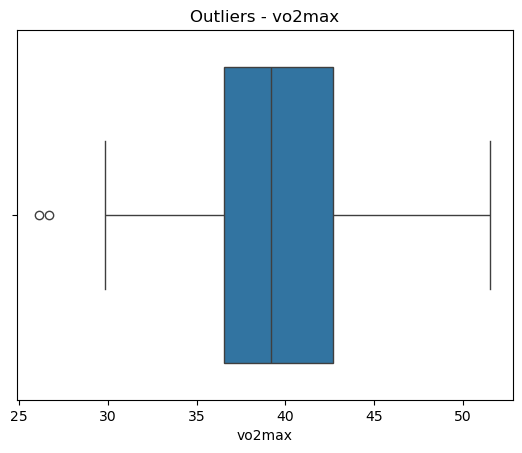

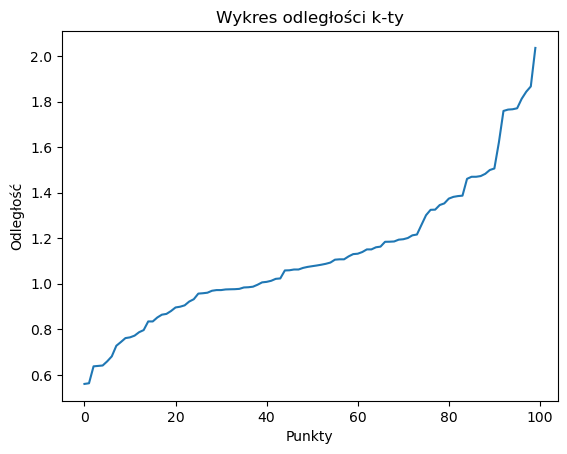

Wykryte klastry: 0
Liczba punktów szumowych: 100


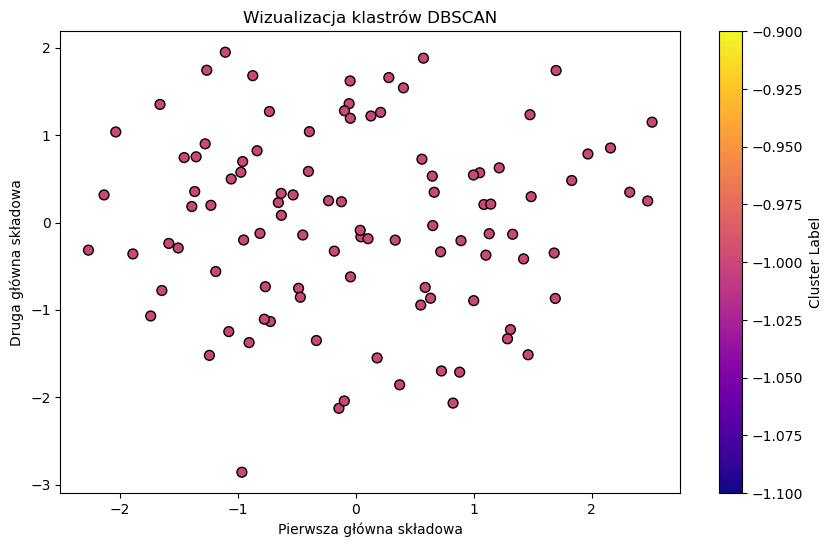

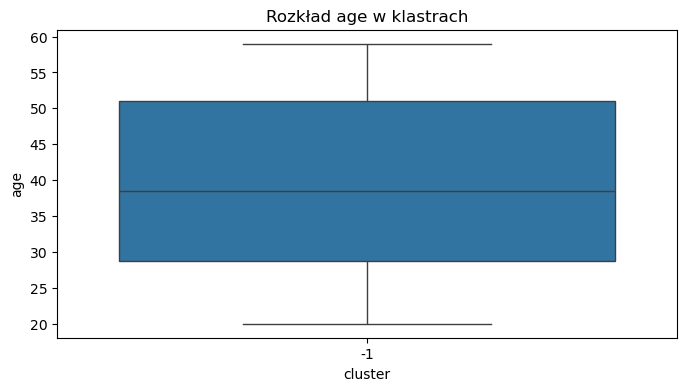

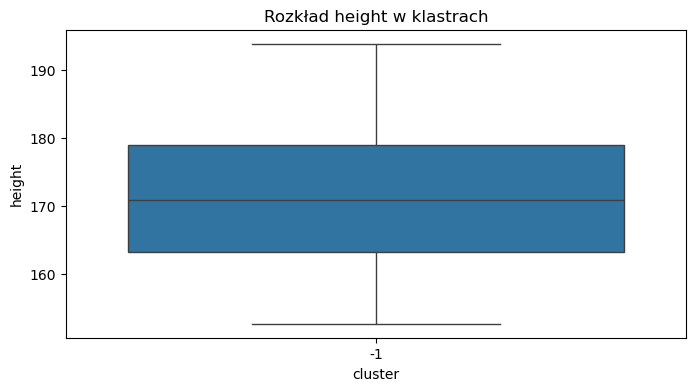

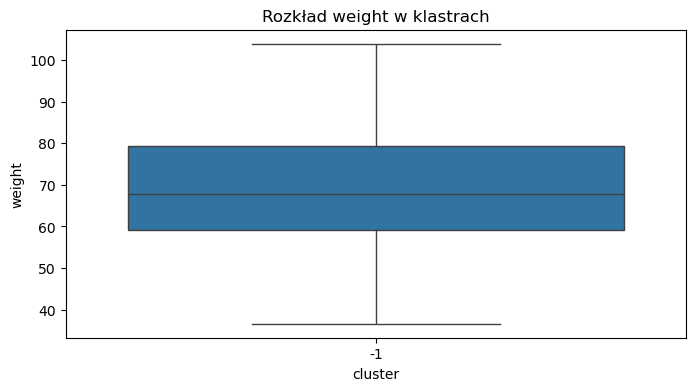

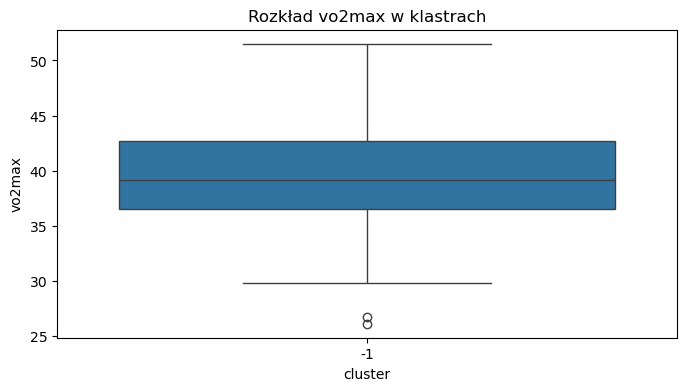

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score

# Przygotowanie przykładowego datasetu, jeśli nie mamy własnego
# df = pd.read_csv('path_to_your_data.csv') # Użyj tego w przypadku własnych danych
np.random.seed(0)
df = pd.DataFrame({
    'age': np.random.randint(20, 60, 100),
    'height': np.random.normal(170, 10, 100),
    'weight': np.random.normal(70, 15, 100),
    'vo2max': np.random.normal(40, 5, 100)
})

# Eksploracyjna analiza danych (EDA)
print(df.describe())  # Podstawowe statystyki
print(df.info())  # Informacje o kolumnach i typach danych
sns.pairplot(df)  # Wykresy par dla szybkiego wglądu w relacje między cechami
plt.show()

# Wykrywanie i wypełnianie braków w danych
df['weight'] = df['weight'].fillna(df['weight'].mean())
df['height'] = df['height'].fillna(df['height'].mean())
df['age'] = df['age'].fillna(df['age'].median())
df['vo2max'] = df['vo2max'].fillna(df['vo2max'].median())

# Dodatkowa analiza - sprawdzenie outliers dla każdej cechy
for feature in ['age', 'height', 'weight', 'vo2max']:
    sns.boxplot(x=df[feature])
    plt.title(f'Outliers - {feature}')
    plt.show()

# Wybór cech do klasteryzacji
features = df[['age', 'height', 'weight', 'vo2max']]

# Normalizacja danych
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Analiza k-distance dla optymalizacji eps
neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(scaled_features)
distances, indices = neighbors_fit.kneighbors(scaled_features)
distances = np.sort(distances[:, 3], axis=0)

plt.plot(distances)
plt.title('Wykres odległości k-ty')
plt.xlabel('Punkty')
plt.ylabel('Odległość')
plt.show()

# Automatyczna optymalizacja eps i min_samples przez analizę wykresu k-distance lub silhouette
eps_value = 0.5  # Przykładowa wartość; ustal wartość po sprawdzeniu wykresu
min_samples_value = 4  # Przykładowa wartość

# Zastosowanie DBSCAN
dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)
clusters = dbscan.fit_predict(scaled_features)
df['cluster'] = clusters

# Analiza wyników klasteryzacji
num_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
noise_points = list(clusters).count(-1)
print(f'Wykryte klastry: {num_clusters}')
print(f'Liczba punktów szumowych: {noise_points}')

# Wartość silhouette (jeśli jest więcej niż 1 klaster)
if num_clusters > 1:
    silhouette_avg = silhouette_score(scaled_features, clusters)
    print(f'Silhouette Score: {silhouette_avg:.2f}')

# Wizualizacja klastrów
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_features)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='plasma', edgecolor='k', s=50)
plt.title('Wizualizacja klastrów DBSCAN')
plt.xlabel('Pierwsza główna składowa')
plt.ylabel('Druga główna składowa')
plt.colorbar(scatter, label='Cluster Label')
plt.show()

# Analiza rozkładu cech w każdym klastrze
for col in features.columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='cluster', y=col, data=df)
    plt.title(f'Rozkład {col} w klastrach')
    plt.show()


Liczba klastrów (bez uwzględnienia -1 jako wartości odstających): 1
Liczba wartości odstających: 13


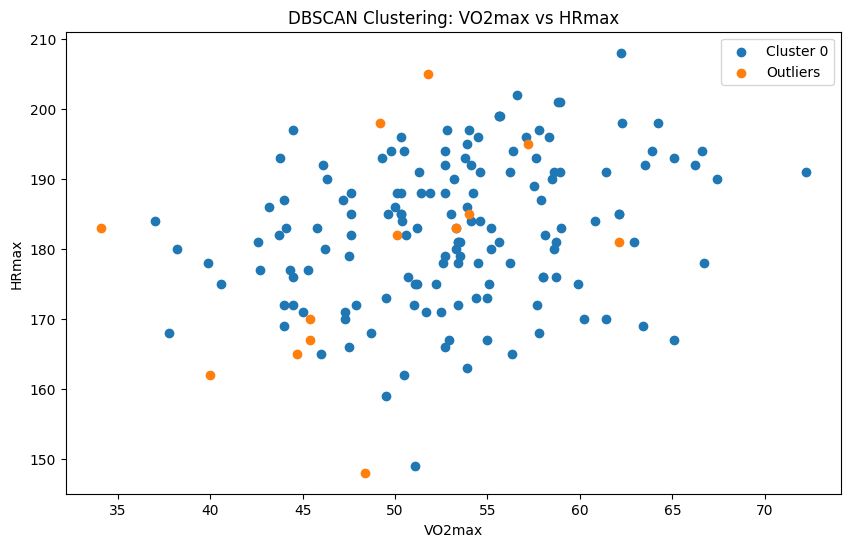

In [6]:

# Załadowanie danych
file_path = 'sport.csv'
data = pd.read_csv(file_path)

# Wybór kluczowych cech
features = data[['vo2max', 'hrmax', 'la_10', 'la_12', 'la_14']]

# Standaryzacja danych
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Implementacja DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=5)  # Parametry do dostrojenia
labels = dbscan.fit_predict(scaled_features)

# Dodanie etykiet klastrów do danych
data['cluster'] = labels

# Analiza wyników
print("Liczba klastrów (bez uwzględnienia -1 jako wartości odstających):", len(set(labels)) - (1 if -1 in labels else 0))
print("Liczba wartości odstających:", sum(labels == -1))

# Wizualizacja klastrów
plt.figure(figsize=(10, 6))
for cluster in set(labels):
    cluster_data = data[data['cluster'] == cluster]
    plt.scatter(cluster_data['vo2max'], cluster_data['hrmax'], label=f"Cluster {cluster}" if cluster != -1 else "Outliers")

plt.title("DBSCAN Clustering: VO2max vs HRmax")
plt.xlabel("VO2max")
plt.ylabel("HRmax")
plt.legend()
plt.show()
 
#Użyliśmy algorytmu DBSCAN, aby zidentyfikować grupy sportowców o podobnych parametrach fizjologicznych oraz wykryć wartości odstające, 
#które mogą reprezentować wyjątkowe przypadki lub błędy w danych. Standaryzacja była konieczna, aby zapewnić porównywalność cech, 
#ponieważ algorytm opiera się na odległościach w przestrzeni wielowymiarowej.

In [12]:
#Co chcemy zrobic 
#1.Poziomy mleczanu (la_10, la_12, la_14)
#Dlaczego? Poziomy mleczanu w różnych intensywnościach wysiłku odzwierciedlają zdolność organizmu do radzenia sobie z wysiłkiem 
#i mogą być dobrym wskaźnikiem różnic między sportowcami.
#Analiza: Sprawdzamy, jak grupują się sportowcy na podstawie ich zdolności metabolizowania mleczanu.
#2. Strefy treningowe (z2, z3, z4, z5)
#Dlaczego? Strefy tętna określają poziomy wysiłku i mogą wskazywać, jak intensywnie dany sportowiec trenuje.
#Analiza: Grupowanie sportowców na podstawie ich dominujących stref wysiłku.
#3 Relacje między age, weight, height
#Dlaczego? Parametry antropometryczne mogą odgrywać kluczową rolę w analizie grup sportowców 
#(np. w dyscyplinach takich jak biegi sprinterskie vs triathlon).
#Analiza: Grupowanie sportowców o podobnych cechach fizycznych.


Liczba klastrów: 1
Liczba wartości odstających: 1

Średnie wartości dla każdego klastra:
         Unnamed: 0      sex      age   height  weight       AeT       AnT  \
cluster                                                                      
-1         140.0000  1.00000  16.0000  192.000  73.000  138.0000  183.0000   
 0          90.1375  0.85625  35.5375  177.175  75.185  143.4875  172.8375   

           vo2max     vo2_at        ve  ...     la_10      hr_12     la_12  \
cluster                                 ...                                  
-1       57.20000  51.600000  142.2000  ...  8.600000  176.00000  3.800000   
 0       52.81625  48.174375  130.9175  ...  2.611875  159.33125  2.851875   

             hr_14    la_14        z2        z3       z4        z5  cluster  
cluster                                                                      
-1       183.00000  4.70000  133.0000  139.0000  171.000  184.0000     -1.0  
 0       170.24375  3.69625  131.0625  144.4875  16

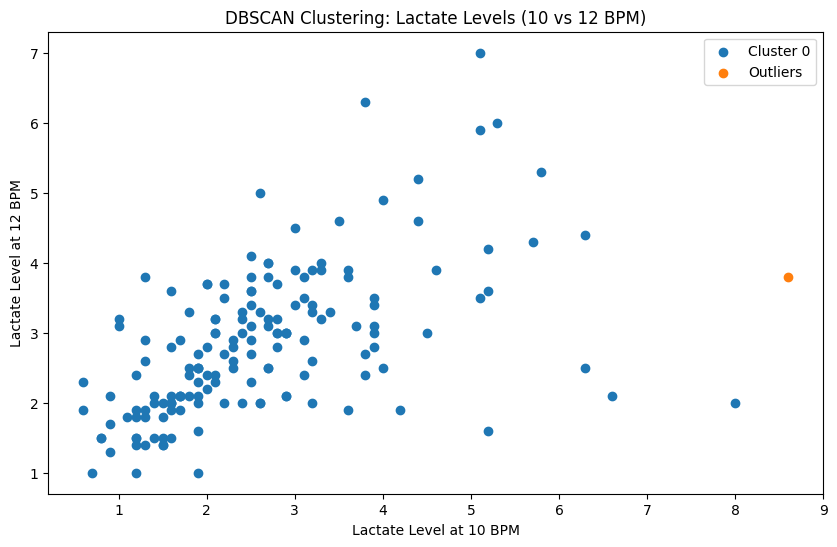


Charakterystyka wartości odstających:
       vo2max  hrmax   age  weight  height
count     1.0    1.0   1.0     1.0     1.0
mean     57.2  195.0  16.0    73.0   192.0
std       NaN    NaN   NaN     NaN     NaN
min      57.2  195.0  16.0    73.0   192.0
25%      57.2  195.0  16.0    73.0   192.0
50%      57.2  195.0  16.0    73.0   192.0
75%      57.2  195.0  16.0    73.0   192.0
max      57.2  195.0  16.0    73.0   192.0

Porównanie klastrów w dodatkowych cechach:
           vo2max  hrmax      age  weight   height
cluster                                           
-1       57.20000  195.0  16.0000  73.000  192.000
 0       52.81625  182.3  35.5375  75.185  177.175


In [16]:
# Importowanie bibliotek
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Wczytanie danych
file_path = 'sport.csv'  # Upewnij się, że ścieżka jest poprawna
data = pd.read_csv(file_path)

# Wybór cech: poziomy mleczanu przy 10 i 12 BPM
features = data[['la_10', 'la_12']]

# Uzupełnianie braków w danych (jeśli istnieją)
features = features.fillna(features.mean())

# Standaryzacja cech - DBSCAN wymaga danych o tej samej skali
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Implementacja DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=5)  # eps i min_samples dostosowane do danych
labels = dbscan.fit_predict(scaled_features)

# Dodanie etykiet klastrów do danych
data['cluster'] = labels

# Analiza klastrów
# Liczba unikalnych klastrów (bez uwzględnienia -1 jako wartości odstających)
num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
num_outliers = sum(labels == -1)

print("Liczba klastrów:", num_clusters)
print("Liczba wartości odstających:", num_outliers)

# Profilowanie klastrów - tylko kolumny numeryczne
numeric_columns = data.select_dtypes(include=['number'])

# Grupowanie po klastrach i obliczanie średnich
cluster_summary = numeric_columns.groupby(data['cluster']).mean()
print("\nŚrednie wartości dla każdego klastra:")
print(cluster_summary)

# Analiza wartości odstających
outliers = data[data['cluster'] == -1]
print("\nWartości odstające:")
print(outliers)

# Wizualizacja wyników klastrów i wartości odstających
plt.figure(figsize=(10, 6))
for cluster in set(labels):
    cluster_data = data[data['cluster'] == cluster]
    plt.scatter(cluster_data['la_10'], cluster_data['la_12'], 
                label=f"Cluster {cluster}" if cluster != -1 else "Outliers")
plt.title("DBSCAN Clustering: Lactate Levels (10 vs 12 BPM)")
plt.xlabel("Lactate Level at 10 BPM")
plt.ylabel("Lactate Level at 12 BPM")
plt.legend()
plt.show()

# Dalsze kroki:
# Sprawdzanie charakterystyki wartości odstających
# Analizujemy, jakie inne cechy wyróżniają te punkty.
outlier_analysis = outliers[['vo2max', 'hrmax', 'age', 'weight', 'height']]
print("\nCharakterystyka wartości odstających:")
print(outlier_analysis.describe())

# Porównanie klastrów pod kątem różnic w cechach
print("\nPorównanie klastrów w dodatkowych cechach:")
print(data.groupby('cluster')[['vo2max', 'hrmax', 'age', 'weight', 'height']].mean())

# Podsumowanie - dalsze kroki:
# 1. Dostosowanie strategii treningowej dla głównych klastrów.
# 2. Identyfikacja odstających i analiza, czy ich parametry odbiegają od normy.


In [ ]:
# Wyniki klastrów:

# Liczba klastrów: 1
# Oznacza, że DBSCAN wykrył tylko jeden klaster (Cluster 0) w analizowanych danych.
# Większość sportowców charakteryzuje się podobnymi poziomami mleczanu przy 10 i 12 BPM,
# dlatego zostali zaklasyfikowani jako jeden klaster.

# Liczba wartości odstających: 1
# Jeden punkt (ID 123) został oznaczony jako wartość odstająca (Cluster -1),
# co oznacza, że jego cechy znacząco odbiegają od reszty sportowców.

# Średnie wartości dla każdego klastra:
# - Cluster -1 (wartości odstające):
#   - Sportowiec ten ma znacznie wyższy poziom mleczanu (la_10 = 8.6) w porównaniu do Cluster 0 (la_10 ≈ 2.61).
#   - Wysokie wartości VO2max (57.2) i HRmax (195) wskazują na dużą wydolność fizyczną.
#   - Jest młodszy (16 lat) i wyższy (192 cm) niż sportowcy z Cluster 0.
# - Cluster 0 (główny klaster):
#   - Typowe cechy większości sportowców, średni poziom VO2max (52.8), HRmax (182.3),
#     mleczanu (la_10 ≈ 2.61, la_12 ≈ 2.85) i wiek ≈ 35 lat.

# Wartości odstające (Cluster -1):
# - Sportowiec ID 123 wyróżnia się:
#   - Bardzo wysokim poziomem mleczanu (la_10 = 8.6, la_12 = 3.8).
#   - Wysokim HRmax (195) i VO2max (57.2), co wskazuje na dużą wydolność.
#   - Nietypowe połączenie cech (młody wiek, wysoki wzrost, wysoki mleczan) może sugerować specyficzne zdolności
#     metaboliczne lub intensywny trening.

# Charakterystyka wartości odstających:
# - Dla Cluster -1 mamy tylko jedną wartość, więc statystyki (min, max, 25%-75%) są identyczne.
# - Sportowiec odstający ma następujące kluczowe cechy:
#   - VO2max: 57.2
#   - HRmax: 195
#   - Wiek: 16
#   - Waga: 73 kg
#   - Wzrost: 192 cm

# Porównanie klastrów w dodatkowych cechach:
# - Cluster -1:
#   - Znacznie wyższe VO2max (57.2) i HRmax (195) w porównaniu do Cluster 0.
#   - Znacznie młodszy (16 lat) niż średni wiek w Cluster 0 (35.5 lat).
#   - Wyższy (192 cm) od sportowców w Cluster 0 (średnio 177 cm).
# - Cluster 0:
#   - Typowe cechy sportowców z bardziej ujednoliconymi wynikami w analizowanych parametrach.

# Wnioski:
# - Cluster -1 (wartość odstająca) reprezentuje sportowca o unikalnych cechach,
#   które mogą wynikać z wyjątkowej wydolności, intensywnego wysiłku lub specyficznego profilu metabolicznego.
# - Cluster 0 to grupa większościowa o przewidywalnych i typowych cechach mleczanu, HRmax i VO2max.
# - Wartość odstająca może wymagać dalszej analizy, aby ustalić, czy jest to błąd pomiaru,
#   wyjątkowy talent, czy odzwierciedlenie specyficznych zdolności.
